# LandingAI ADE Python Library Examples

This notebook demonstrates various usage patterns for the ADE (Automated Document Extraction) Python library.

In [ ]:
# LandingAI ADE Python SDK
!pip install landingai-ade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
# For .env authentication file support
!pip install pydantic_settings
# install pillow for image processing
!pip install pillow
# install pymupdf for pdf processing
!pip install pymupdf
# install matplotlib for visualization
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 65.3 MB/s eta 0:00:00


## 1. Authentication

In [ ]:
# Method 1: Environment variable
def get_api_key() -> str:
    import os

    key = os.environ.get("VISION_AGENT_API_KEY")
    if not key:
        raise ValueError(
            "API key not found. Please set the VISION_AGENT_API_KEY environment variable."
        )
    return key


# Method 2: From .env file with Pydantic settings
def get_api_key_env() -> str:
    from pydantic_settings import BaseSettings

    class Settings(BaseSettings):
        vision_agent_api_key: str

        class Config:
            env_file = ".env"

    settings = Settings()
    return settings.vision_agent_api_key


# Initialize the client
from landingai_ade import LandingAIADE

client = LandingAIADE(apikey=get_api_key_env())

print("Authenticated client initialized")

Authenticated client initialized


## 2. Parse

### 2.1. Full document

In [ ]:
from pathlib import Path

from landingai_ade.types import ParseResponse


model = "dpt-2-latest"
parse_filename = "wire-transfer.pdf"
full_parse_result: ParseResponse = client.parse(document=Path(parse_filename), model=model)

print("Global markdown:", full_parse_result.markdown[:200] + "...")
print(f"Number of chunks: {len(full_parse_result.chunks)}")

Global markdown: <a id='37eec11f-f777-43e7-b05e-3a99bbdc872e'></a>

WIRE TRANSFER FORM

<a id='a3d1292b-f2c7-461f-80c3-f762968ff45a'></a>

Invoice Information

Invoice Description:
Professional consulting services - Q...
Number of chunks: 10


### 2.2. Per pages

In [ ]:
parse_result_per_pages: ParseResponse = client.parse(document=Path(parse_filename), split="page", model=model)

print("Global markdown:", parse_result_per_pages.markdown[:200] + "...")
print(f"Number of chunks: {len(parse_result_per_pages.chunks)}")
print(f"Amount of pages: {len(parse_result_per_pages.splits)}")

Global markdown: <a id='b90b4532-8430-422c-bffa-fb0c3987d27a'></a>

WIRE TRANSFER FORM

<a id='c089f484-3f4c-4255-bd7b-b3370715aff6'></a>

Invoice Information

Invoice Description:
Professional consulting services - Q...
Number of chunks: 10
Amount of pages: 2


## 3. Extraction

### 3.1. Document markdown

In [ ]:
from pydantic import BaseModel, Field

from landingai_ade.types import ExtractResponse
from landingai_ade.lib import pydantic_to_json_schema


# Define extraction schemas
class WireTransferInfo(BaseModel):
    bank_name: str = Field(
        description="The name of the beneficiary bank as listed in the wire transfer form.",
        title="Bank Name",
    )
    bank_account_number: int = Field(
        description="The account number of the beneficiary bank as listed in the wire transfer form.",
        title="Bank Account Number",
    )


def extract_schema(
    client: LandingAIADE, markdown: str, schema_class: BaseModel
) -> ExtractResponse:
    """Extract structured data from markdown using a Pydantic schema."""
    json_schema = pydantic_to_json_schema(schema_class)
    response = client.extract(schema=json_schema, markdown=markdown)
    return response


full_extraction_result = extract_schema(client, full_parse_result.markdown, WireTransferInfo)

print("Bank Name:", full_extraction_result.extraction["bank_name"])
print("Account Number:", full_extraction_result.extraction["bank_account_number"])

Bank Name: JPMorgan Chase Bank, N.A.
Account Number: 4578923456789012


### 3.2. Chunk's markdown

In [ ]:
class BeneficiaryInfoSchema(BaseModel):
    name: str = Field(
        description="The name of the beneficiary.",
        title="Beneficiary Name",
    )
    bank_name: str = Field(
        description="The name of the beneficiary's bank.",
        title="Bank Name",
    )
    swift_code: str = Field(
        description="The SWIFT code of the beneficiary's bank.",
        title="SWIFT Code",
    )
    address: str = Field(
        description="The address of the beneficiary.",
        title="Beneficiary Address",
    )


final_extraction_result = {}
for chunk in full_parse_result.chunks:
    extraction_result = extract_schema(client, chunk.markdown, BeneficiaryInfoSchema)
    print(extraction_result.extraction)
    for key, value in extraction_result.extraction.items():
        if value:
            final_extraction_result[key] = value
    if final_extraction_result.keys() == extraction_result.extraction.keys():
        break
print("Final Extraction:", final_extraction_result)

{'name': '', 'bank_name': '', 'swift_code': '', 'address': ''}
{'name': '', 'bank_name': '', 'swift_code': '', 'address': ''}
{'name': '', 'bank_name': 'JPMorgan Chase Bank, N.A.', 'swift_code': 'CHASUS33', 'address': '270 Park Avenue, New York, NY 10017, USA'}
{'name': '', 'bank_name': '', 'swift_code': '', 'address': ''}
{'name': 'ABC Consulting Services LLC', 'bank_name': '', 'swift_code': '', 'address': ''}
Final Extraction: {'bank_name': 'JPMorgan Chase Bank, N.A.', 'swift_code': 'CHASUS33', 'address': '270 Park Avenue, New York, NY 10017, USA', 'name': 'ABC Consulting Services LLC'}


### 3.3. Page's markdown

In [ ]:
class Invoice(BaseModel):
    number: str = Field(
        description="The unique identifier for the invoice.",
        title="Invoice Number",
    )

schema_per_page = [WireTransferInfo, Invoice]

for idx, split in enumerate(parse_result_per_pages.splits):
    extraction_result = extract_schema(client, split.markdown, schema_per_page[idx])
    print(extraction_result.extraction)

{'bank_name': 'JPMorgan Chase Bank, N.A.', 'bank_account_number': 4578923456789012}
{'number': 'INV-2025-0847'}


## 4. Classification

In [ ]:
from typing import Literal


class DocType(BaseModel):
    type: Literal["pay_stub", "tax_form", "bank_statement", "investment_statement"] = (
        Field(
            description="The type of the document.",
            title="Document Type",
        )
    )


class BankStatementSchema(BaseModel):
    bank_name: str = Field(
        description="The name of the bank.",
        title="Bank Name",
    )
    account_number: str = Field(
        description="The bank account number.",
        title="Account Number",
    )
    balance: float = Field(
        description="The current balance of the bank account.",
        title="Balance",
    )


class TaxFormSchema(BaseModel):
    tax_year: int = Field(
        description="The tax year for the form.",
        title="Tax Year",
    )
    total_income: float = Field(
        description="The total income reported on the tax form.",
        title="Total Income",
    )
    tax_paid: float = Field(
        description="The total tax paid as reported on the tax form.",
        title="Tax Paid",
    )


class PaymentStubSchema(BaseModel):
    employee_name: str = Field(
        description="The name of the employee.",
        title="Employee Name",
    )
    pay_period: str = Field(
        description="The pay period for the stub.",
        title="Pay Period",
    )
    gross_pay: float = Field(
        description="The gross pay amount.",
        title="Gross Pay",
    )
    net_pay: float = Field(
        description="The net pay amount after deductions.",
        title="Net Pay",
    )


documents = ["bank.pdf", "earnings.pdf", "tax.jpg"]
schema_per_doc_type = {
    "bank_statement": BankStatementSchema,
    "tax_form": TaxFormSchema,
    "pay_stub": PaymentStubSchema,
}
final_extraction_result = {}

for document in documents:
    parse_result: ParseResponse = client.parse(document=Path(document), model=model)
    extraction_result = extract_schema(client, parse_result.markdown, DocType)
    doc_type = extraction_result.extraction["type"]
    print("Document Type Extraction:", doc_type)
    extraction_result = extract_schema(client, parse_result.markdown, schema_per_doc_type[doc_type])
    print("Detailed Extraction:", extraction_result.extraction)
    final_extraction_result[document] = {
        "type": doc_type,
        "data": extraction_result.extraction
    }

print(final_extraction_result)

Document Type Extraction: bank_statement
Detailed Extraction: {'bank_name': 'Royal Bank of Canada', 'account_number': '02782-5094431', 'balance': 3664.79}
Document Type Extraction: pay_stub
Detailed Extraction: {'employee_name': 'JANE HARPER', 'pay_period': '03/19/2021', 'gross_pay': 452.43, 'net_pay': 291.9}
Document Type Extraction: tax_form
Detailed Extraction: {'tax_year': 2024, 'total_income': 2323.0, 'tax_paid': 232.3}
{'bank.pdf': {'type': 'bank_statement', 'data': {'bank_name': 'Royal Bank of Canada', 'account_number': '02782-5094431', 'balance': 3664.79}}, 'earnings.pdf': {'type': 'pay_stub', 'data': {'employee_name': 'JANE HARPER', 'pay_period': '03/19/2021', 'gross_pay': 452.43, 'net_pay': 291.9}}, 'tax.jpg': {'type': 'tax_form', 'data': {'tax_year': 2024, 'total_income': 2323.0, 'tax_paid': 232.3}}}


## 5. Saving Results

In [ ]:
import json
from datetime import datetime


def save_parse_results(
    results: ParseResponse, parse_filename: str, output_dir: str = "./ade_results"
) -> None:
    """Save ADE parse results."""
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_filename = f"parse_{Path(parse_filename).stem}_{timestamp}"

    results_json = json.dumps(results.model_dump(), indent=2, default=str)
    json_path = output_path / f"{base_filename}.json"

    with open(json_path, "w", encoding="utf-8") as f:
        f.write(results_json)

    print(f"Parse results saved to: {json_path}")


def save_extraction_results(
    results: ExtractResponse, markdown: str, output_dir: str = "./ade_results"
) -> None:
    """Save ADE extraction results."""
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    markdown_filename = "markdown.md"
    with open(output_path / markdown_filename, "w", encoding="utf-8") as f:
        f.write(markdown)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_filename = f"extraction_{Path(markdown_filename).stem}_{timestamp}"

    extraction_json = json.dumps(results.model_dump(), indent=2, default=str)
    json_path = output_path / f"{base_filename}.json"

    with open(json_path, "w", encoding="utf-8") as f:
        f.write(extraction_json)

    print(f"Extraction results saved to: {json_path}")


# Example usage
save_parse_results(full_parse_result, parse_filename)
save_extraction_results(full_extraction_result, full_parse_result.markdown)

# Show the output files
print("Output files:")
output_dir = Path("./ade_results")
for json_file in output_dir.glob("*.json"):
    print(f" - {json_file.name}")

Parse results saved to: ade_results/parse_wire-transfer_20251003_174911.json
Extraction results saved to: ade_results/extraction_markdown_20251003_174911.json
Output files:
 - extraction_markdown_20251003_174911.json
 - parse_wire-transfer_20251003_174911.json
 - extraction_markdown_20251003_174638.json
 - parse_wire-transfer_20251003_174638.json


## 6. Visualization

Saved page 1 to: ade_results/wire-transfer_page_1_20251003_174935.png
Saved annotated page 1 to: ade_results/wire-transfer_page_1_annotated_20251003_174935.png


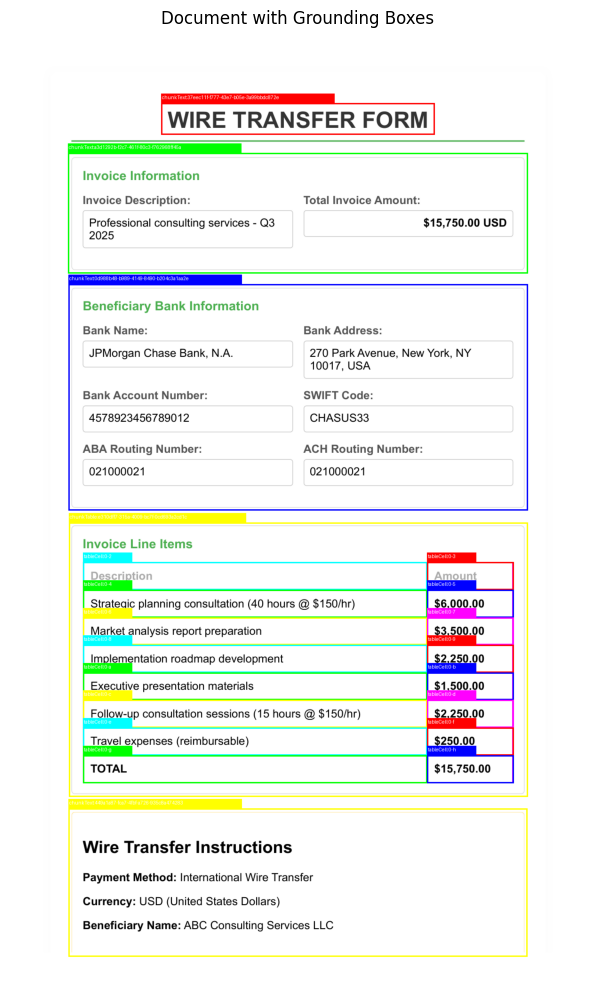

Saved page 2 to: ade_results/wire-transfer_page_2_20251003_174935.png
Saved annotated page 2 to: ade_results/wire-transfer_page_2_annotated_20251003_174935.png


In [ ]:
from typing import Dict

import pymupdf
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from landingai_ade.types.parse_response import Grounding


def create_annotated_image(
    img: Image.Image, groundings: Dict[str, Grounding], page_num: int
) -> Image.Image:
    """Create an annotated image with grounding boxes and labels."""
    annotated_img = img.copy()
    draw = ImageDraw.Draw(annotated_img)
    colors = [
        (255, 0, 0),
        (0, 255, 0),
        (0, 0, 255),
        (255, 255, 0),
        (255, 0, 255),
        (0, 255, 255),
    ]

    img_width, img_height = img.size
    color_idx = 0

    for gid, grounding in groundings.items():
        # Check if grounding belongs to this page (for PDFs)
        if grounding.page != page_num:
            continue

        box = grounding.box

        # Extract coordinates from box
        left, top, right, bottom = box.left, box.top, box.right, box.bottom

        # Convert to pixel coordinates
        x1 = int(left * img_width)
        y1 = int(top * img_height)
        x2 = int(right * img_width)
        y2 = int(bottom * img_height)

        # Draw bounding box
        color = colors[color_idx % len(colors)]
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)

        # Draw label background and text
        label = f"{grounding.type}:{gid}"
        label_y = max(0, y1 - 20)
        draw.rectangle([x1, label_y, x1 + len(label) * 8, y1], fill=color)
        draw.text((x1 + 2, label_y + 2), label, fill=(255, 255, 255))

        color_idx += 1

    return annotated_img


def save_image_with_timestamp(
    img: Image.Image, output_path: Path, base_name: str, suffix: str, timestamp: str
) -> Path:
    """Save image with timestamp and return the path."""
    filename = f"{base_name}_{suffix}_{timestamp}.png"
    image_path = output_path / filename
    img.save(image_path)
    return image_path


def display_image_in_jupyter(
    img: Image.Image, title: str = "Document with Grounding Boxes"
) -> None:
    """Display image in Jupyter notebook."""
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


def process_pdf_pages(
    pdf_path: str, response: ParseResponse, output_path: Path, timestamp: str
) -> None:
    """Process all pages of a PDF document."""
    pdf = pymupdf.open(pdf_path)
    total_pages = len(pdf)
    base_name = Path(pdf_path).stem

    for page_num in range(total_pages):
        page = pdf[page_num]
        pix = page.get_pixmap(matrix=pymupdf.Matrix(2, 2))  # 2x scaling
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        # Save original page
        original_path = save_image_with_timestamp(
            img, output_path, base_name, f"page_{page_num + 1}", timestamp
        )
        print(f"Saved page {page_num + 1} to: {original_path}")

        # Create and save annotated version
        if response.grounding:
            annotated_img = create_annotated_image(img, response.grounding, page_num)
            annotated_path = save_image_with_timestamp(
                annotated_img,
                output_path,
                base_name,
                f"page_{page_num + 1}_annotated",
                timestamp,
            )
            print(f"Saved annotated page {page_num + 1} to: {annotated_path}")

            # Only display first page in Jupyter
            if page_num == 0:
                display_image_in_jupyter(annotated_img)

    pdf.close()


def process_image_file(
    image_path: str, response: ParseResponse, output_path: Path, timestamp: str
) -> None:
    """Process a single image file."""
    img = Image.open(image_path)
    if img.mode != "RGB":
        img = img.convert("RGB")

    base_name = Path(image_path).stem

    # Save original image
    original_path = save_image_with_timestamp(
        img, output_path, base_name, "", timestamp
    )
    print(f"Saved image to: {original_path}")

    # Create and save annotated version
    if response.grounding:
        annotated_img = create_annotated_image(img, response.grounding)
        annotated_path = save_image_with_timestamp(
            img, output_path, base_name, "annotated", timestamp
        )
        print(f"Saved annotated image to: {annotated_path}")

        # Display in Jupyter
        display_image_in_jupyter(annotated_img)


def visualize_document(
    response: ParseResponse, parse_filename: str, output_dir: str = "./ade_results"
) -> None:
    """Visualize document groundings for debugging and save all pages."""
    if response.grounding is None or len(response.grounding) == 0:
        print("No groundings found in response")
        return

    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Handle both PDF and image files
    if parse_filename.lower().endswith(".pdf"):
        process_pdf_pages(parse_filename, response, output_path, timestamp)
    elif parse_filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
        process_image_file(parse_filename, response, output_path, timestamp)


# Example usage
visualize_document(full_parse_result, parse_filename)